In [1]:
import sys
import os
import io
import requests
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), 'libsvm\python')))
from svmutil import *
from svm import *

In [2]:
# load data from url
def load_data():
    url="http://www.cs.nyu.edu/~mohri/yml/spambase.data.shuffled"
    s=requests.get(url).content
    data=pd.read_csv(io.StringIO(s.decode('utf-8')),index_col=False,header=None)
    return  data#.values.tolist()

#convert csv format to required format for svm-scale
def construct_line( label, line ):
    new_line = []
    if float( label ) == 0.0:
        label = "0"
    new_line.append( label )

    for i, item in enumerate( line ):
        if item == '' or float( item ) == 0.0:
            continue
        new_item = "%s:%s" % ( i + 1, item )
        new_line.append( new_item )
    new_line = " ".join( new_line )
    new_line += "\n"
    return new_line

data = load_data()
filename = 'spambase.txt'
data.to_csv(filename,header = False,index = False)


# prepare for scaling

In [3]:
features_len = 57
# scale
input_file = filename
output_file = filename+'.ready_to_scale'
i = open( input_file, 'rb' )
o = open( output_file, 'wb' )
reader = csv.reader(i)
dataset = []
for line in reader:
    label = line.pop(features_len)
    new_line = construct_line( label, line )
    o.write(new_line)
    dataset.append(new_line)
i.close()    
o.close()

# split on train and test set

In [4]:
train = dataset[:3450]
test = dataset[3450:]

train_file = 'spam/train.txt'
test_file = 'spam/test.txt'
train_scale_file = 'spam/train.scale.txt'
test_scale_file = 'spam/test.scale.txt'

trainfile = open(train_file, 'w')
for item in train:
    trainfile.write(item)
trainfile.close()

testfile = open(test_file, 'w')
for item in test:
    testfile.write(item)
testfile.close()


# scale train and test set

In [5]:
os.system('libsvm\windows\svm-scale.exe -l -1 -u 1 -s spam/scale_params ' + train_file + ' > ' + train_scale_file )
os.system('libsvm\windows\svm-scale.exe -r spam/scale_params ' + test_file + '> ' + test_scale_file)

0

In [7]:
def get_dataset(filename,features_len):
    o = open(filename, 'r' )
    features = []    
    for line in o:
        splitted = line.split(' ')
        feature_row = [0.0 for i in xrange(features_len+1)]
        feature_row[0] = int(splitted[0])
        for f in splitted[1:-1]:
            k, v = f.split(':')
            feature_row[int(k)]=float(v)
        features.append(feature_row)
    return features

In [8]:
train = get_dataset(train_scale_file,features_len)
test  = get_dataset(test_scale_file,features_len)

# 10-fold validation

In [9]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    fold_size = int(len(dataset) / n_folds)
    np.random.shuffle(dataset)
    splits = []
    for i in xrange(n_folds):
        part_before = dataset[:fold_size*i]
        part_after = dataset[fold_size*(i + 1):]
        validation_part = dataset[fold_size*i : fold_size*(i + 1)]
        training_part = part_before + part_after
        splits.append((training_part, validation_part))
    return splits

In [47]:
splits = cross_validation_split(train, 10)

d_list = [1, 2, 3, 4]
k_list = range(-20, 20, 5) 


In [34]:
def make_param_tunning():       
    stats = []  
    for d in d_list:
        for k in k_list:
            C = 2**k
            print("d = %d k = %d" % (d, k))
            risks = []
            for split in splits:

                train = split[0]
                split_X_train = [sublist[1:] for sublist in train]
                split_y_train = [sublist[0] for sublist in train]

                validation = split[1]
                split_X_validation = [sublist[1:] for sublist in validation]
                split_y_validation = [sublist[0] for sublist in validation]

                prob  = svm_problem(split_y_train, split_X_train)
                param = svm_parameter('-h 0 -t 1 -d '+ str(d) +' -c ' + str(C))
                m = svm_train(prob, param)

                p_label, p_acc, p_val  = svm_predict(split_y_validation, split_X_validation, m , ' -q')
                acc, risk, _= evaluations(split_y_validation, p_label)
                risks.append(risk)
            print((d, k, C, np.mean(risks), np.std(risks)))
            stats.append((d, k, C, np.mean(risks), np.std(risks)))
    return stats


In [ ]:
statistics = make_param_tunning()

In [58]:
s = sorted(statistics, key = lambda x: (x[1],x[0]))
s ##(d, k, C, error, std)

[(1, -20, 9.5367431640625e-07, 0.39275362318840579, 0.024190311749224723),
 (2, -20, 9.5367431640625e-07, 0.39275362318840579, 0.024190311749224723),
 (3, -20, 9.5367431640625e-07, 0.39275362318840579, 0.024190311749224723),
 (4, -20, 9.5367431640625e-07, 0.39275362318840579, 0.024190311749224723),
 (1, -15, 3.0517578125e-05, 0.39275362318840579, 0.024190311749224723),
 (2, -15, 3.0517578125e-05, 0.39275362318840579, 0.024190311749224723),
 (3, -15, 3.0517578125e-05, 0.39275362318840579, 0.024190311749224723),
 (4, -15, 3.0517578125e-05, 0.39275362318840579, 0.024190311749224723),
 (1, -10, 0.0009765625, 0.39275362318840579, 0.024190311749224723),
 (2, -10, 0.0009765625, 0.39275362318840579, 0.024190311749224723),
 (3, -10, 0.0009765625, 0.39275362318840579, 0.024190311749224723),
 (4, -10, 0.0009765625, 0.39275362318840579, 0.024190311749224723),
 (1, -5, 0.03125, 0.39275362318840579, 0.024190311749224723),
 (2, -5, 0.03125, 0.39275362318840579, 0.024190311749224723),
 (3, -5, 0.03125

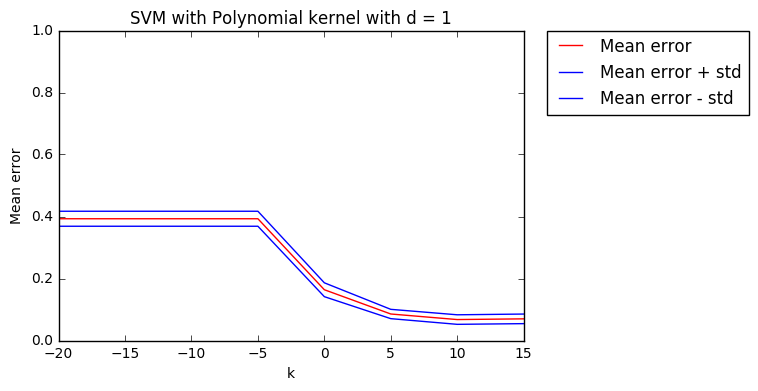

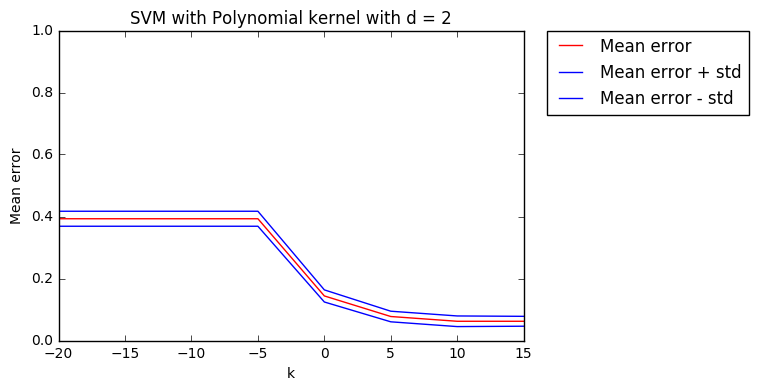

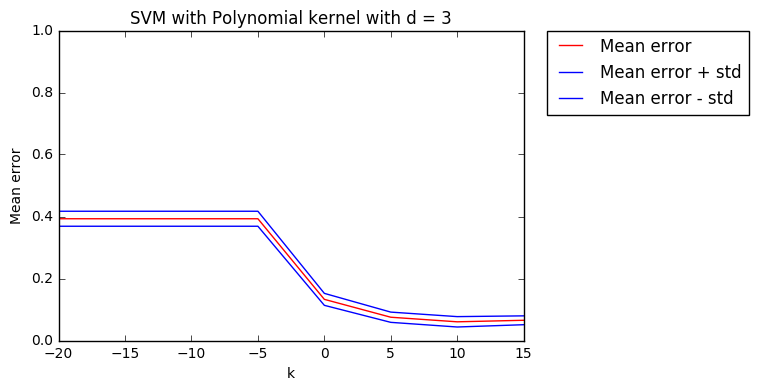

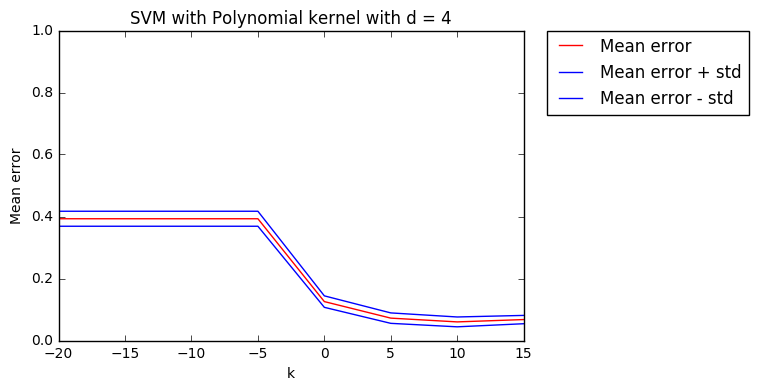

In [59]:
def plot(x_C, y_mean, y_mean_p_std, y_mean_m_std, d):
    plt.title("SVM with Polynomial kernel with d = "+ str(d))
    plt.xlabel("k")
    plt.ylabel("Mean error")    
    plt.plot(x_C,y_mean,'r', label="Mean error")
    plt.plot(x_C,y_mean_p_std,'b' , label = "Mean error + std")
    plt.plot(x_C,y_mean_m_std,'b', label = "Mean error - std")
    plt.axis([min(x_C),max(x_C),0,1])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return plt

for degree in d_list:
    stats_d = [l for l in statistics if l[0] == degree]
    zipped = zip(*stats_d)
    d, k, x_C, y_mean, y_std = zipped
    y_mean_p_std = [i + j for i,j in zip(y_mean,y_std)]
    y_mean_m_std = [i - j for i,j in zip(y_mean,y_std)]
    p = plot(k, y_mean, y_mean_p_std, y_mean_m_std, degree)
    p.show()

Графики показывают, что при больших С все SVM работают одинково хорошо, а при маленьких С одинаково плохо.

# Best params

In [69]:
ordered_params = sorted(statistics, key = lambda x: (x[3], x[4])) # min mean error and min std
print("Top 3 params: ")
print(ordered_params[:3])
best_params = ordered_params[0]
print("\nBest param: ")
print(best_params)

Top 3 params: 
[(4, 10, 1024, 0.059999999999999998, 0.015878661941799811), (3, 10, 1024, 0.060289855072463774, 0.016741482989210032), (2, 15, 32768, 0.062028985507246372, 0.015939393721585534)]

Best param: 
(4, 10, 1024, 0.059999999999999998, 0.015878661941799811)


## (C\*, d\*) = (1024, 4)

In [103]:
d_, k_, C_, mean_, std_ = best_params

# Testing model on test set

In [99]:
X_train = [sublist[1:] for sublist in train]
y_train = [sublist[0] for sublist in train]

X_test = [sublist[1:] for sublist in test]
y_test = [sublist[0] for sublist in test]

risks = []
sv_d = []
for degree in d_list:
    prob  = svm_problem(y_train, X_train)
    param = svm_parameter('-h 0 -t 1 -d '+ str(degree) +' -c ' + str(C_))
    m = svm_train(prob, param)
    p_label, p_acc, p_val  = svm_predict(y_test, X_test, m , ' -q')
    acc, test_risk, _= evaluations(y_test, p_label)
    sv = m.get_nr_sv()
    sv_d.append((degree,sv))
    risks.append((degree,test_risk))


# Compare risk on validation and test set

In [100]:
deg_error_validation = [(s[0],s[3]) for s in statistics if s[1] == k_ ]
print(deg_error_validation)
print(risks)

[(1, 0.067536231884057968), (2, 0.062028985507246379), (3, 0.060289855072463774), (4, 0.059999999999999998)]
[(1, 0.07993049522154648), (2, 0.07124239791485665), (3, 0.06950477845351868), (4, 0.06950477845351868)]


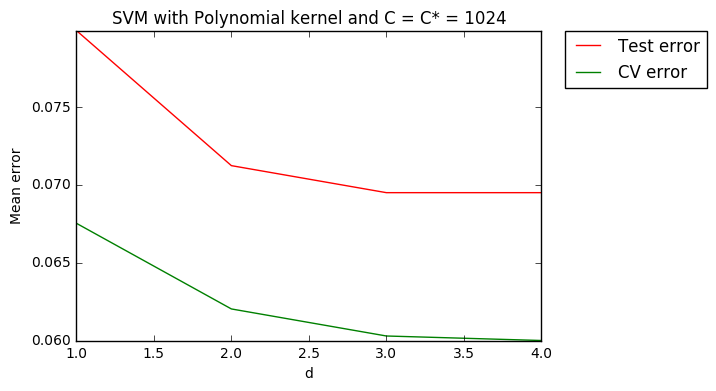

In [105]:
def plot_validation_emp_risk(d, y1, y2):
    plt.title("SVM with Polynomial kernel and C = C* = " + str(C_))
    plt.xlabel("d")
    plt.ylabel("Mean error")    
    plt.plot(d, y1,'r', label="Test error")
    plt.plot(d, y2,'g' , label = "CV error ")
    plt.axis([min(d),max(d),min(y1+ y2), max(y1+y2)])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return plt


test_r = zip(*risks)
val_risk = zip(*deg_error_validation)
d, y1 = test_r
d, y2 = val_risk
p = plot_validation_emp_risk(d, y1, y2)
p.show()



# Support vectors count  as functions of d

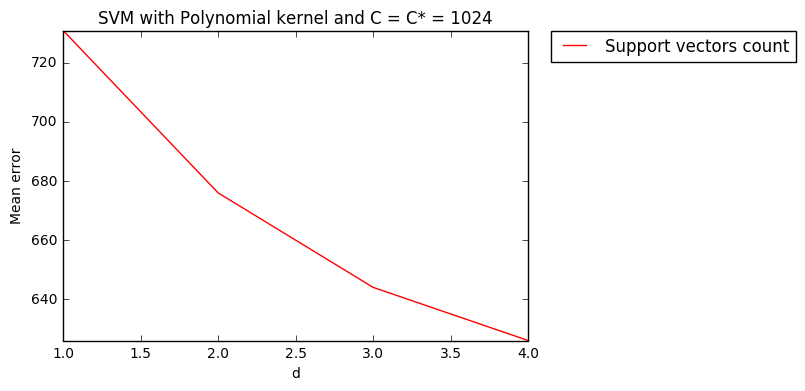

In [106]:
plt.title("SVM with Polynomial kernel and C = C* = " + str(C_))
d,sv = zip(*sv_d)
plt.xlabel("d")
plt.ylabel("Mean error")    
plt.plot(d, sv,'r', label="Support vectors count")
plt.axis([min(d),max(d),min(sv),max(sv)])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Наилучшим образом показала себя модель SVM с полиномиальным ядром 4ой степени и C = 1024. Количество опорных векторов равно 626. 